In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle

In [ ]:
class CarDataset(Dataset):
    def __init__(self, base_path):
        self.base_path = base_path
        
    def __len__(self):
        return len(os.listdir(self.base_path))
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        with open(f'{self.base_path}/{idx}.pkl','rb') as input:
            car = pickle.load(input)
            
        return car

In [1]:
import torch
import pytorch3d
from MeshFitter.CarMesh import *

In [2]:
mesh = CarMesh()

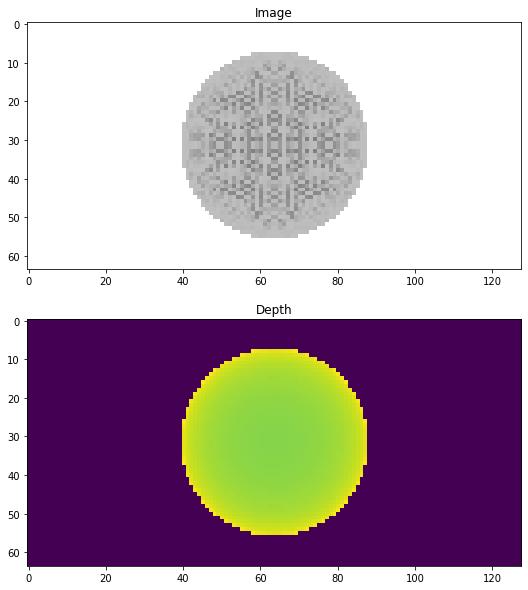

In [3]:
mesh.plot()